## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
path = Path('/kaggle/input/')
path.ls()

[PosixPath('/kaggle/input/train-jpg'),
 PosixPath('/kaggle/input/test-jpg-additional'),
 PosixPath('/kaggle/input/test-jpg'),
 PosixPath('/kaggle/input/train_v2.csv')]

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [6]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(sep=' '))

In [7]:
data = (src.transform(tfms, size=128)
        .databunch(num_workers=0).normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

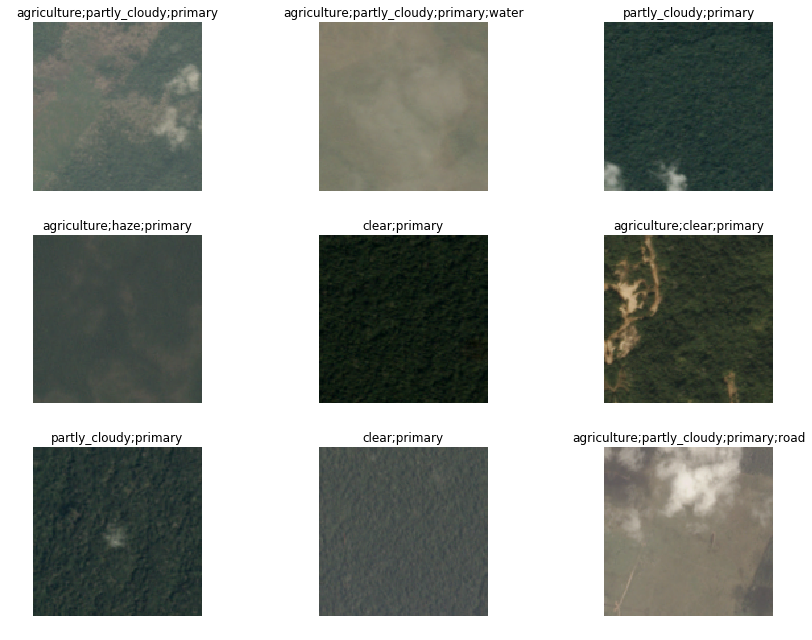

In [8]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [9]:
arch = models.resnet50

In [10]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score], model_dir='/tmp/models')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 89699990.99it/s]


We use the LR Finder to pick a good learning rate.

In [11]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


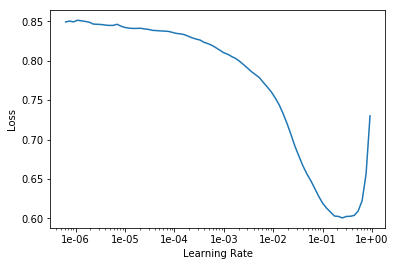

In [12]:
learn.recorder.plot()

Then we can fit the head of our network.

In [13]:
lr = 0.01

In [14]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.120848,0.113145,0.946874,0.901005
2,0.115339,0.096342,0.948690,0.917232
3,0.102709,0.094432,0.957643,0.917089
4,0.095959,0.088239,0.956960,0.924170
5,0.090337,0.086981,0.956465,0.924811


In [15]:
learn.save('stage-1-rn50')

...And fine-tune the whole model:

In [16]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


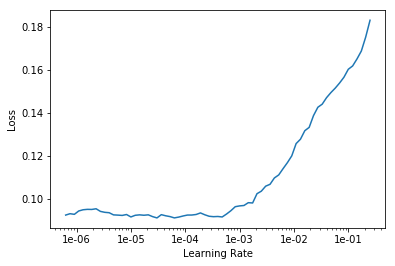

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.097055,0.090733,0.955092,0.921006
2,0.099335,0.090720,0.952476,0.921902
3,0.092400,0.085031,0.955921,0.926174
4,0.084105,0.083424,0.959583,0.928161
5,0.078512,0.082539,0.958551,0.929325


In [19]:
learn.save('stage-2-rn50')

So far we have improved our model by unfreezing and using custom learning rates. How can we improve our model again? 
When we created our dataset, we put `size=128` whereas the images that Kaggle gave us are 256. We used the size of 128 partially because we wanted to experiment quickly. It's much quicker and easier to use small images to experiment. But there's a second reason. We now have a model that's pretty good at recognizing the contents of 128 by 128 satellite images. So what we are going to do if we now want to create a model that's pretty good at 256 by 256 satellite images? Why don't we use transfer learning? Why don't we start with the model that's good at 128 by 128 images and fine-tune that? So don't start again. That's actually going to be really interesting because if we trained quite a lot and we're on the verge of overfitting then we're basically creating a whole new dataset effectively﹣one where our images are twice the size on each axis right so four times bigger. So it's really a totally different data set as far as our convolutional neural networks concerned. So we got to lose all that overfitting. we get to start again. Let's keep our same learner but use a new data bunch where the data bunch is 256 by 256.

We now create a new databunch (`data`) and replace our learner's databunch with the new databunch (`learn.data = data`)

In [20]:
data = (src.transform(tfms, size=256)
        .databunch(num_workers=0).normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [21]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


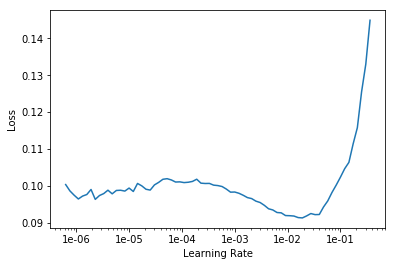

In [22]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr=1e-2/2

In [24]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.085572,0.084659,0.958631,0.926315
2,0.086466,0.086126,0.957664,0.926033
3,0.085463,0.082267,0.958951,0.928491
4,0.081550,0.081928,0.958995,0.928959
5,0.081240,0.081437,0.959416,0.930144


In [25]:
learn.save('stage-1-256-rn50')

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.082587,0.084728,0.953210,0.927740
2,0.084904,0.084835,0.960026,0.927337
3,0.081068,0.084025,0.957911,0.927342
4,0.079898,0.080831,0.959873,0.930567
5,0.076336,0.080986,0.959300,0.930649


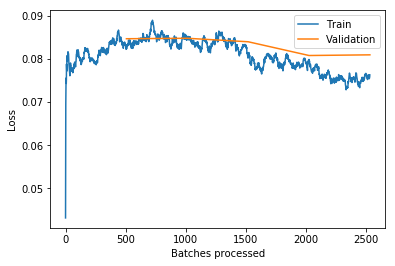

In [30]:
learn.recorder.plot_losses()

In [31]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

In [ ]:
learn.export()

## fin

(This section will be covered in part 2 - please don't ask about it just yet! :) )

In [ ]:
test = ImageItemList.from_folder(path/'test-jpg').add(ImageItemList.from_folder(path/'test-jpg-additional'))
len(test)

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [ ]:
df.to_csv(path/'submission.csv', index=False)

Private Leaderboard score: 0.9296 (around 80th)